# Lab8 Reframing Design Pattern

The *Reframing design pattern* refers to changing the representation of the output of a machine learning problem. For example, we could take something that is intuitively a regression problem and instead pose it as a classification problem (and vice versa).


Note: For the code that has been provided to  you, try to understand what each line does, especially the part where the code is making inputs for the TensorFlow (TF) model. The TF part of the program can be a little nitty gritty, which is why we have provided it to  you. You can use your lab time to understand the code that has been provided to you. Please ask for help from your TA or instructor if you have questions.

Save your file as <uteid_Lab8>.ipynb and submit as your submission




In this lab, we will look at the natality dataset from Google Cloud Public Datasets. It is a set of free, publically available data hosted in BigQuery. Notice that for a given set of inputs, the weight_pounds (the label) can take many different values. 

In [3]:
# These are all the modules that we will need for this lab. 
import numpy as np
import seaborn as sns
from google.cloud import bigquery

import matplotlib as plt
%matplotlib inline
import os
# As discussed in the class, you will have to create a free account on Google Cloud Platform, enable BigQuery API and create
# a credential file associated with your project. Save this file to your computer. Ensure that the file is in your operating
# systems search path. The name of your file may be different from gcp.json.

credential_path = "gcp.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

In [4]:
#Create a big query client
bq = bigquery.Client()

In [7]:
#Set a query with the following parameters
query = """
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  plurality,
  mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND is_male = true
  AND gestation_weeks = 38
  AND mother_age = 28
  AND mother_race = 1
  AND plurality = 1
  AND RAND() < 0.01
"""

In [8]:
#Convert the query to a dataframe so that other modules can use it
df = bq.query(query).to_dataframe()
df.head()

,weight_pounds,is_male,gestation_weeks,mother_age,plurality,mother_race
0,6.102395,True,38,28,1,1
1,6.876218,True,38,28,1,1
2,7.749249,True,38,28,1,1
3,7.374463,True,38,28,1,1
4,9.186662,True,38,28,1,1


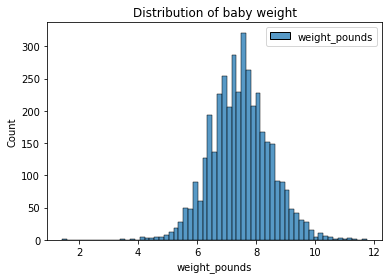

In [9]:
#Plot the baby weight to see the distribution
fig = sns.histplot(df[["weight_pounds"]])
fig.set_title("Distribution of baby weight")
fig.set_xlabel("weight_pounds")
fig.figure.savefig("weight_distrib.png")

In [10]:
# Task1 0.5 points
# Add code here to calculate and print the average weight_pounds for this cross section**


In [11]:
# Task2 0.5 points
# Add code here to calculate and print the standard deviation for weight_pounds for this cross section**


In [5]:
# Task 3 0.5 points
# Add code here to do the following
# Create a new query for for the same parameters as in Cell 7, expect the plurality is equal to 2 (Twins). 
# Calculate and print the average weight_pounds for this cross section 
# Calculate and print the standard deviation for this cross section. 


## Comparing categorical label and regression

Since baby weight is a positive real value, this is intuitively a regression problem. However, we can train the model as a multi-class classification by bucketizing the output label. At inference time, the model then predicts a collection of probabilities corresponding to these potential outputs. 

Let's do both and see how they compare. 

In [11]:
import pandas as pd
import tensorflow as tf


from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [12]:
#Read the provided dataset. Please specify the correct path. On my computer, the file was in a folder
# data
df = pd.read_csv("./data/babyweight_train.csv")

We'll use the same features for both models. But we need to create a categorical weight label for the classification model. 

In [13]:
# prepare inputs
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

# create categorical label
def categorical_weight(weight_pounds):
    if weight_pounds < 3.31:
        return 0
    elif weight_pounds >= 3.31 and weight_pounds < 5.5:
        return 1
    elif weight_pounds >= 5.5 and weight_pounds < 8.8:
        return 2
    else:
        return 3

df["weight_category"] = df.weight_pounds.apply(lambda x: categorical_weight(x))

In [14]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race,weight_category
0,7.749249,False,12,Single(1),40,1.0,2
1,7.561856,True,12,Single(1),40,2.0,2
2,7.187070,False,12,Single(1),34,3.0,2
3,6.375769,True,12,Single(1),36,2.0,2
4,7.936641,False,12,Single(1),35,0.0,2


In [15]:
def encode_labels(classes):
    one_hots = to_categorical(classes)
    return one_hots

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']

LABEL_CLS = ['weight_category']
LABEL_REG = ['weight_pounds']

N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]

y_train_cls = encode_labels(df[LABEL_CLS][:N_TRAIN])
y_train_reg = df[LABEL_REG][:N_TRAIN]

y_valid_cls = encode_labels(df[LABEL_CLS][N_TRAIN:])
y_valid_reg = df[LABEL_REG][N_TRAIN:]

Create `tf.data` datsets for both classification and regression.

In [16]:
# train/validation dataset for classification model
cls_train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train_cls))
cls_valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid_cls))

# train/validation dataset for regression model
reg_train_data = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train_reg.values))
reg_valid_data = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid_reg.values))

In [17]:
# Examine the two datasets. Notice the different label values.
for data_type in [cls_train_data, reg_train_data]:
    for dict_slice in data_type.take(1):
        print("{}\n".format(dict_slice))

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 1., 0.], dtype=float32)>)

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([7.74924851])>)



In [ ]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

In [ ]:
# create Inputs for model
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# create hidden layers
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)

# create classification model
cls_output = layers.Dense(4, activation="softmax")(h2)
cls_model = tf.keras.models.Model(inputs=inputs, outputs=cls_output)
cls_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])   


# create regression model
reg_output = layers.Dense(1, activation="relu")(h2)
reg_model = tf.keras.models.Model(inputs=inputs, outputs=reg_output)
reg_model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])   

First, train the classification model and examine the validation accuracy. 

In [ ]:
# Task 4 0.5 points
# Add code here to do the following
# Train the classification model created above, with training data batch size of 50 and 1 epoch. 
# Calculate and print your results for validation accuracy

#HINT: model.evaluate(valid_data.batch(X_valid_dataset.shape[0])) returns the loss,accuracy as a tuple for a regression model
#change variable names

# Note, you can experiment with different batch sizes and epochs for your learning. But for submission, only print
# results for batch size of 50 and 1 epoch


Next, we'll train the regression model and examine the validation MSE

In [ ]:
# Task 5 0.5 points
# Add code here to do the following
# Train the regression model created above, with training data batch size of 50 and 1 epoch. 
# Calculate and print your results for validation MSE

#HINT: model.evaluate(valid_data.batch(X_valid_dataset.shape[0])) returns the loss,MSE as a tuple for a regression model
#change variable names

# Note, you can experiment with different batch sizes and epochs for your learning. But for submission, only print
# results for batch size of 50 and 1 epoch


The regression model gives a single numeric prediction of baby weight. 

In [ ]:
# Task 6 0.5 points
# Add code here to do the following
# Calculate the prediction for the regression model using built-in predict function
# Calculate the prediction for the following input value
    # is_male = true
    # gestation_weeks = 38
    # mother_age = 28
    # mother_race = 1
    # plurality = 1


# HINT: The code below shows how to make an input to the model, run it, and get the output
    # How to make an input to the model
    # preds = model.predict( x={
    #     "column_name_float32": tf.convert_to_tensor([float32 (e.g. 38)]),
    #     "column_name_string": tf.convert_to_tensor([string boolean (e.g. "True")]),
    # }, steps=1).squeeze();
    # 
# the 'x=...' part inside of model.predict function

# Now looking at the dtypes for each of the columns in a cell above (code has been copied below, so 
# that you don't have to find it)

    # inputs = {colname: tf.keras.layers.Input(
    #     name=colname, shape=(), dtype="float32")
    #     for colname in ["mother_age", "gestation_weeks"]}
    # inputs.update({colname: tf.keras.layers.Input(
    #     name=colname, shape=(), dtype=tf.string)
    #     for colname in ["plurality", "is_male", "mother_race"]})

# Figure out how to make a correct input for the model, with the correct types

# Print the prediction value
#Does this value make sense to you based on the query you did at the beginning of this tutorial?


The classification model predicts a probability for each bucket of values. 

In [ ]:
# Task 7 0.5 points

# Add code here to do the following

# Calculate the prediction for the classification model using built-in predict function
# Calculate the prediction for the following input value
    # is_male = true
    # gestation_weeks = 38
    # mother_age = 28
    # mother_race = 1
    # plurality = 1


# HINT: The code below shows how to make an input to the model, run it, and get the output
    # How to make an input to the model
    # preds = model.predict( x={
    #     "column_name_float32": tf.convert_to_tensor([float32 (e.g. 38)]),
    #     "column_name_string": tf.convert_to_tensor([String (e.g. "True")]),
    #     ...
    # }, steps=1).squeeze();
    # 
# the 'x=...' part inside of model.predict function

# Now looking at the dtypes for each of the columns in a cell above (code has been copied below, so 
# that you don't have to find it)

    # inputs = {colname: tf.keras.layers.Input(
    #     name=colname, shape=(), dtype="float32")
    #     for colname in ["mother_age", "gestation_weeks"]}
    # inputs.update({colname: tf.keras.layers.Input(
    #     name=colname, shape=(), dtype=tf.string)
    #     for colname in ["plurality", "is_male", "mother_race"]})

# Figure out how to make a correct input for the model, with the correct types, based on the first code snippet
# using your knowledge of what type each column takes

# Print the prediction value
# Note that it returns an array of size 4. What do each of these values mean
# HINT: Think about probabilities

#Do these values make sense based on the query from the beginning of the tutorial?





In [ ]:
# Task 8 0.5 points
# Add code here to do the following
# Plot a histogram of the predictions calculated for the classifcation model
# Your histogram must have 4 bars for each of the 4 categories that you created above
    
    # For your convenience, the code from above copied has been copied here 
        # def categorical_weight(weight_pounds):
        #     if weight_pounds < 3.31: #"category 1"
        #         return 0
        #     elif weight_pounds >= 3.31 and weight_pounds < 5.5: #"category 2"
        #         return 1
        #     elif weight_pounds >= 5.5 and weight_pounds < 8.8: #"category 3"
        #         return 2
        #     else:
        #         return 3 #"category 4"

# (although some may be so short that they are not visible) 

# #ex code to make a bar graph, that meets our standards
# import matplotlib.pyplot as plt
# %matplotlib inline
# xvals = [1,2,3,4]
# yvals = [5,2,4,1]
# plt.bar(xvals, yvals, alpha=.5)
# plt.xticks(xvals, ("column1", "column2", "column3", "column4"))
# plt.show()

# Does the graph look similar to the histogram from the the beginning of this tutorial?

